In [7]:
import scipy
import utils as ut
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
from datetime import datetime
import pytz
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from scipy import stats
from sklearn.preprocessing import StandardScaler

In [11]:
stocks = ut.get_df('../data/stocks-prepared-to-analyze.csv')
tweets = ut.get_df('../data/tweets-prepared-to-analyze.csv')
df = pd.merge(tweets, stocks, on='Date')
df.drop(columns=['Unnamed: 0'], inplace=True)
tweet_counts = df.groupby('Date').size()
df['tweet_count'] = df['Date'].map(tweet_counts)
# 1 -> zvyseni, -1 -> snizeni
df['net_close_effect'] = df['Close_n_diff_%'].apply(lambda x: 1 if x >= 0 else -1)
#df.drop(columns=['Close_diff_%'], inplace=True)
df

,Date,category,to,text,mentions_c,hashtags_c,day_of_week,positive,negative,neutral,...,url_video,polarity,subjectivity,time_of_day,Close,Volume,Close_n,Close_n_diff_%,tweet_count,net_close_effect
0,2012-02-01,neutral,NaN,Just test-fired the Superdraco rocket engine. ...,0,0,2,0,0,1,...,0,0.266667,0.350000,7.500000,1.972000,0.002613,0.001108,0.081210,2,1
1,2012-02-01,positive,NaN,"Um, while awesome in its own way, that was not...",0,0,2,1,0,0,...,0,0.266667,0.350000,7.500000,1.972000,0.002613,0.001108,0.081210,2,1
2,2012-01-31,positive,NaN,The SpaceX theme song by Total Ghost is just t...,0,0,1,1,0,0,...,1,0.350000,0.675000,11.000000,1.938000,0.009765,0.001025,-0.073746,1,-1
3,2012-01-27,positive,NaN,The Model X unveiling will be webcast live on ...,0,0,4,1,0,0,...,0,0.394318,0.696970,18.000000,1.955333,0.006331,0.001067,0.063415,2,1
4,2012-01-27,positive,NaN,Beautiful picture of Earth from the new NASA s...,0,0,4,1,0,0,...,0,0.394318,0.696970,18.000000,1.955333,0.006331,0.001067,0.063415,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6529,2020-04-02,negative,elonmusk,Weird that so many troll/bot accounts were act...,0,0,3,0,1,0,...,0,0.115595,0.400952,16.714286,30.298000,0.321814,0.070458,-0.059049,14,-1
6530,2020-04-02,positive,flcnhvy,"Yeah, very important to provide C/BiPAP device...",0,0,3,1,0,0,...,0,0.115595,0.400952,16.714286,30.298000,0.321814,0.070458,-0.059049,14,-1
6531,2020-04-02,negative,elonmusk,Invasive ventilators are for worst case patien...,0,0,3,0,1,0,...,0,0.115595,0.400952,16.714286,30.298000,0.321814,0.070458,-0.059049,14,-1
6532,2020-04-02,positive,28delayslater,"Exactly. Moreover, all hospitals were given ex...",0,0,3,1,0,0,...,0,0.115595,0.400952,16.714286,30.298000,0.321814,0.070458,-0.059049,14,-1


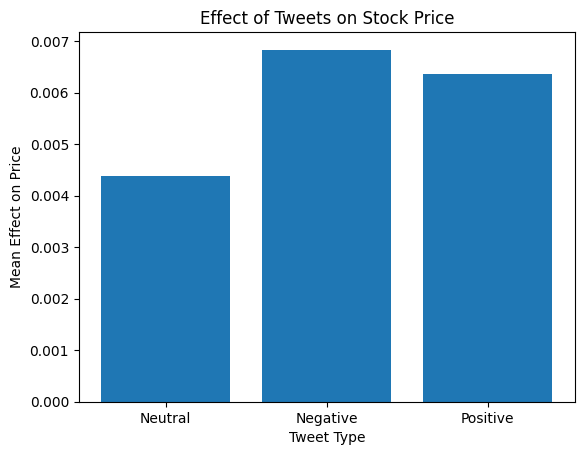

In [59]:
# Разделите данные на два DataFrame по типам твиттов
neutrals_ = df[df['neutral'] == 1]
negatives_ = df[df['negative'] == 1]
positives_ = df[df['positive'] == 1]
neutrals = neutrals_
negatives = negatives_
positives = positives_
effect_data = pd.DataFrame({'Effect': [neutrals['Close_n_diff_%'].mean(), negatives['Close_n_diff_%'].mean(), positives['Close_n_diff_%'].mean()]},
                           index=['Neutral Tweets', 'Negative Tweets', 'Positive Tweets'])

# Добавление информации о типе твитта в DataFrame
effect_data['Tweet_Type'] = ['Neutral', 'Negative', 'Positive']

# Построение графика
plt.bar(effect_data['Tweet_Type'], effect_data['Effect'])
plt.xlabel('Tweet Type')
plt.ylabel('Mean Effect on Price')
plt.title('Effect of Tweets on Stock Price')
plt.show()

## Prev price 

In [13]:
def find_prev(row):
    row_idx = row.name
    prev_row = df.iloc[row_idx - 1]
    if(row_idx <= 0):
            return 0
    while prev_row['Date'] == row['Date']:
        row_idx -= 1
        if(row_idx <= 0):
            return 0
        prev_row = df.iloc[row_idx - 1]
    return prev_row['Close']

df['prev_close'] = df.apply(find_prev, axis=1)
df['to_c'] = df['to'].notnull()
df['to_c'] = df['to_c'].astype(int)
df

,Date,category,to,text,mentions_c,hashtags_c,day_of_week,positive,negative,neutral,...,subjectivity,time_of_day,Close,Volume,Close_n,Close_n_diff_%,tweet_count,net_close_effect,prev_close,to_c
0,2012-02-01,neutral,NaN,Just test-fired the Superdraco rocket engine. ...,0,0,2,0,0,1,...,0.350000,7.500000,1.972000,0.002613,0.001108,0.081210,2,1,0.000000,0
1,2012-02-01,positive,NaN,"Um, while awesome in its own way, that was not...",0,0,2,1,0,0,...,0.350000,7.500000,1.972000,0.002613,0.001108,0.081210,2,1,0.000000,0
2,2012-01-31,positive,NaN,The SpaceX theme song by Total Ghost is just t...,0,0,1,1,0,0,...,0.675000,11.000000,1.938000,0.009765,0.001025,-0.073746,1,-1,1.972000,0
3,2012-01-27,positive,NaN,The Model X unveiling will be webcast live on ...,0,0,4,1,0,0,...,0.696970,18.000000,1.955333,0.006331,0.001067,0.063415,2,1,1.938000,0
4,2012-01-27,positive,NaN,Beautiful picture of Earth from the new NASA s...,0,0,4,1,0,0,...,0.696970,18.000000,1.955333,0.006331,0.001067,0.063415,2,1,1.938000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6529,2020-04-02,negative,elonmusk,Weird that so many troll/bot accounts were act...,0,0,3,0,1,0,...,0.400952,16.714286,30.298000,0.321814,0.070458,-0.059049,14,-1,32.000668,1
6530,2020-04-02,positive,flcnhvy,"Yeah, very important to provide C/BiPAP device...",0,0,3,1,0,0,...,0.400952,16.714286,30.298000,0.321814,0.070458,-0.059049,14,-1,32.000668,1
6531,2020-04-02,negative,elonmusk,Invasive ventilators are for worst case patien...,0,0,3,0,1,0,...,0.400952,16.714286,30.298000,0.321814,0.070458,-0.059049,14,-1,32.000668,1
6532,2020-04-02,positive,28delayslater,"Exactly. Moreover, all hospitals were given ex...",0,0,3,1,0,0,...,0.400952,16.714286,30.298000,0.321814,0.070458,-0.059049,14,-1,32.000668,1


C:\Users\OMEN\AppData\Local\Temp\ipykernel_32304\1118246186.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.iloc[::].corr()


,category,to,text,mentions_c,hashtags_c,day_of_week,positive,negative,neutral,closely_related,...,subjectivity,time_of_day,Close,Volume,Close_n,Close_n_diff_%,tweet_count,net_close_effect,prev_close,to_c
Date,,,,,,,,,,,,,,,,,,,,,
2012-02-01,neutral,NaN,Just test-fired the Superdraco rocket engine. ...,0,0,2,0,0,1,0,...,0.350000,7.500000,1.972000,0.002613,0.001108,0.081210,2,1,0.000000,0
2012-02-01,positive,NaN,"Um, while awesome in its own way, that was not...",0,0,2,1,0,0,0,...,0.350000,7.500000,1.972000,0.002613,0.001108,0.081210,2,1,0.000000,0
2012-01-31,positive,NaN,The SpaceX theme song by Total Ghost is just t...,0,0,1,1,0,0,0,...,0.675000,11.000000,1.938000,0.009765,0.001025,-0.073746,1,-1,1.972000,0
2012-01-27,positive,NaN,The Model X unveiling will be webcast live on ...,0,0,4,1,0,0,1,...,0.696970,18.000000,1.955333,0.006331,0.001067,0.063415,2,1,1.938000,0
2012-01-27,positive,NaN,Beautiful picture of Earth from the new NASA s...,0,0,4,1,0,0,1,...,0.696970,18.000000,1.955333,0.006331,0.001067,0.063415,2,1,1.938000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-02,negative,elonmusk,Weird that so many troll/bot accounts were act...,0,0,3,0,1,0,0,...,0.400952,16.714286,30.298000,0.321814,0.070458,-0.059049,14,-1,32.000668,1
2020-04-02,positive,flcnhvy,"Yeah, very important to provide C/BiPAP device...",0,0,3,1,0,0,0,...,0.400952,16.714286,30.298000,0.321814,0.070458,-0.059049,14,-1,32.000668,1
2020-04-02,negative,elonmusk,Invasive ventilators are for worst case patien...,0,0,3,0,1,0,0,...,0.400952,16.714286,30.298000,0.321814,0.070458,-0.059049,14,-1,32.000668,1


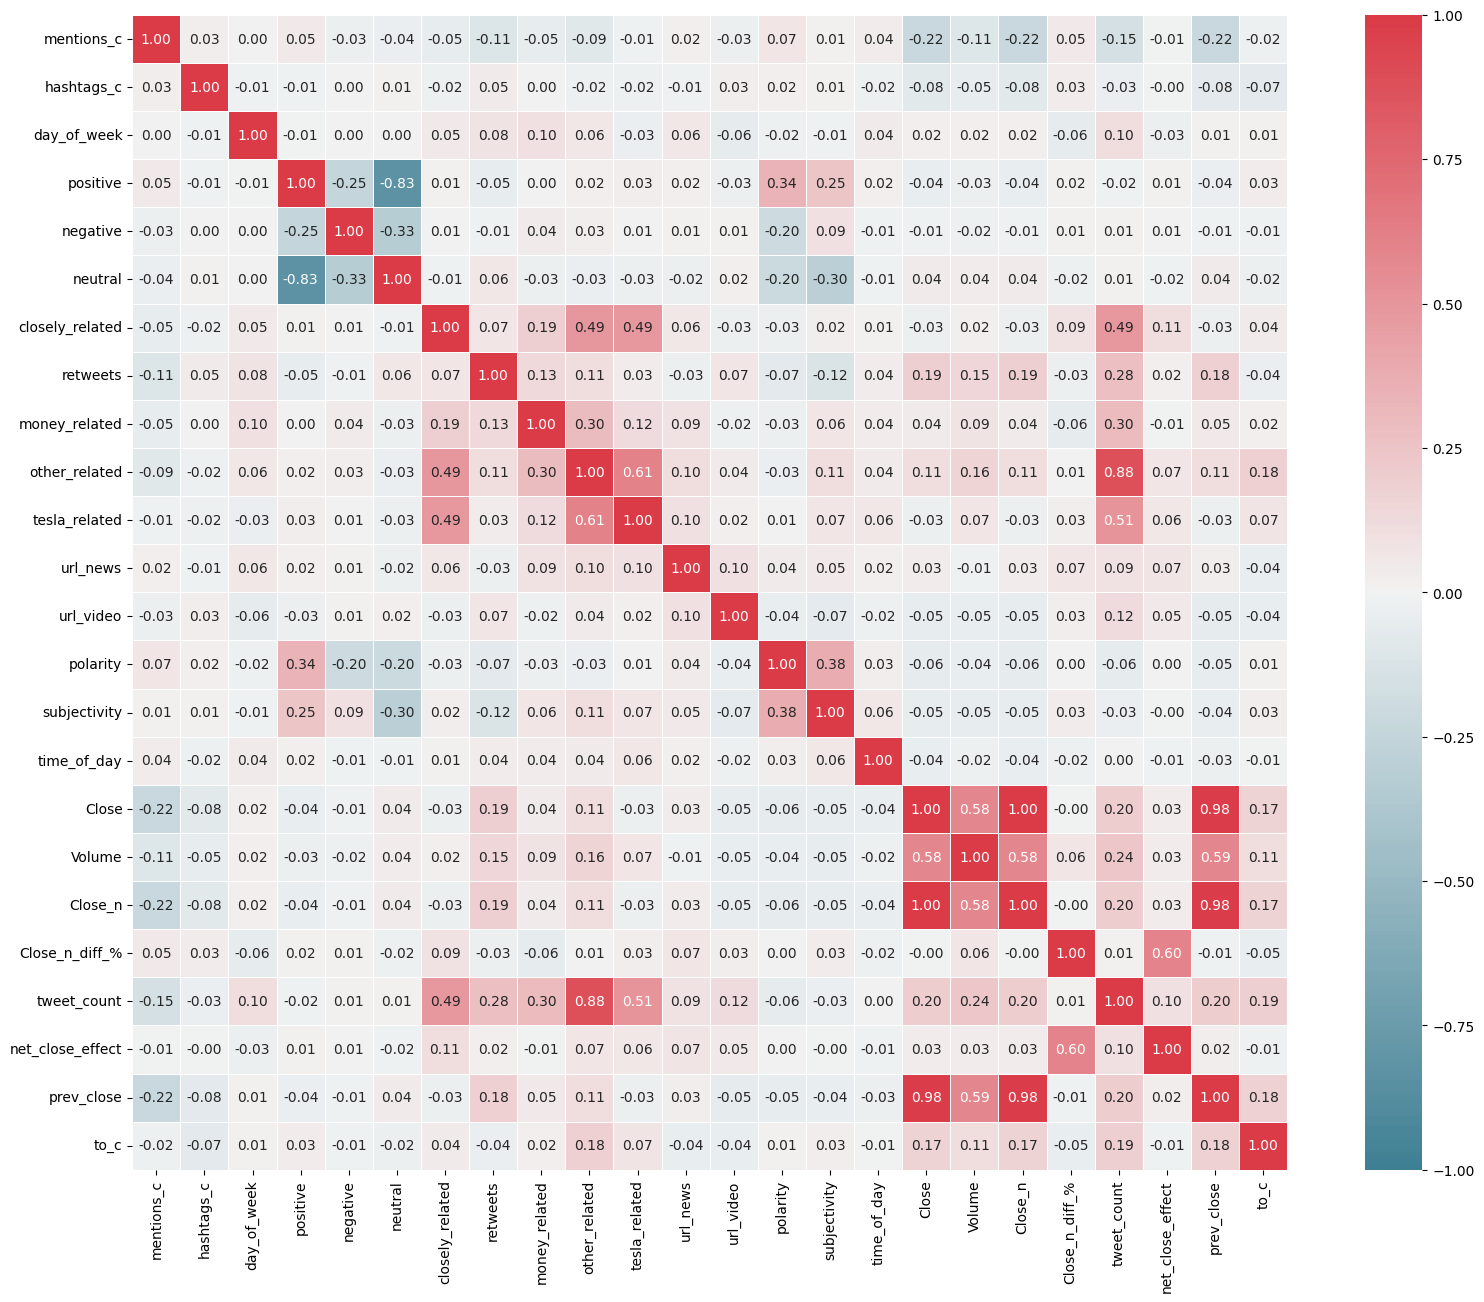

In [14]:
df.index = df['Date']
df.drop(columns=['Date'], inplace=True)
correlation_matrix = df.iloc[::].corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.subplots(figsize=(20,15))
sns.heatmap(correlation_matrix, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5,  annot=True, fmt=".2f")
df

C:\Users\OMEN\AppData\Local\Temp\ipykernel_32304\3364463169.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr(method='spearman')


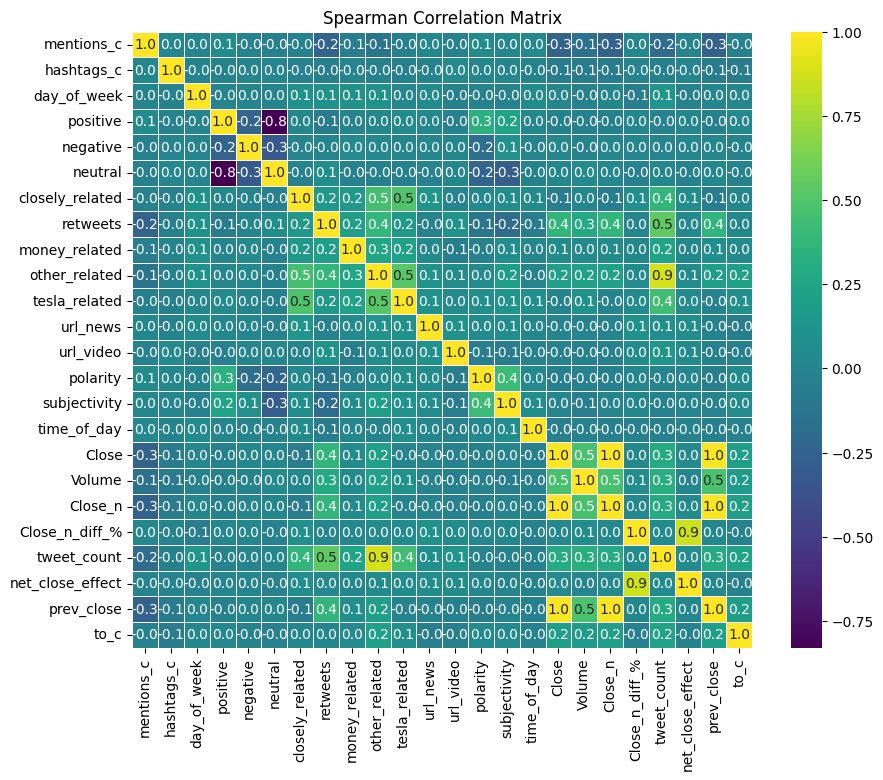

In [16]:
correlation_matrix = df.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='viridis', annot=True, cbar=True, fmt=".1f", linewidths=0.5)
plt.title("Spearman Correlation Matrix")
plt.show()

# Provedeme analyzu staticke vyznamnosti.

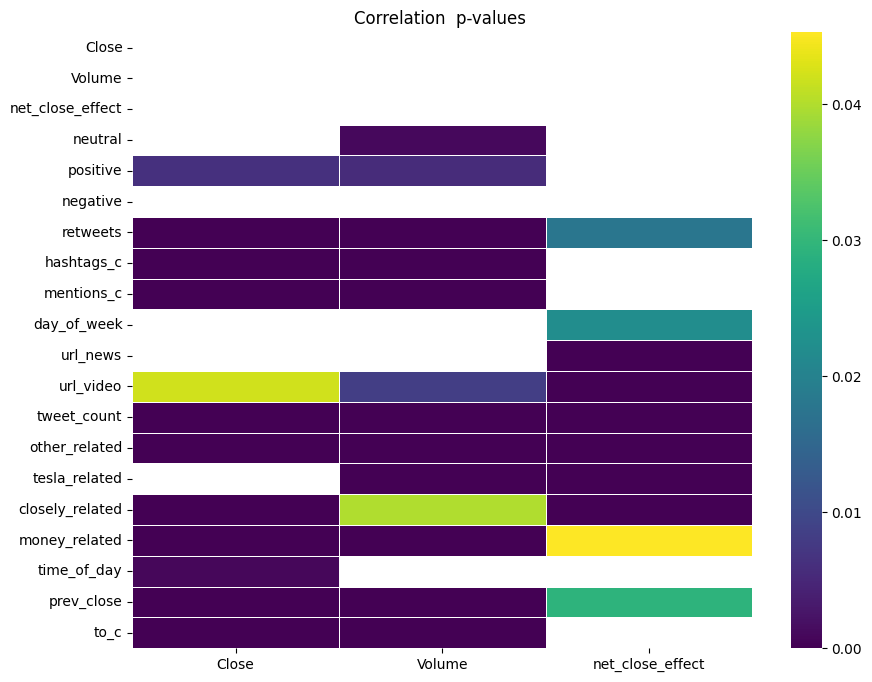

In [39]:
import pandas as pd
from scipy.stats import spearmanr

data = df[['Close','Volume', 'net_close_effect']]
data2 = df[['neutral', 'positive', 'negative', 'retweets', 'hashtags_c', 'mentions_c', 'day_of_week', 'url_news', 'url_video',
           'tweet_count','other_related', 'tesla_related', 'closely_related', 'money_related', 'time_of_day', 'prev_close', 'to_c']]

alpha = 0.05


def get_pvalue(x, y):
    _, p_value = spearmanr(x, y)
    return p_value

p_values = pd.DataFrame(columns=data.columns, index=data.columns)


for col1 in data2.columns:
    for col2 in data.columns:
        p_values.loc[col1, col2] = get_pvalue(data2[col1], data[col2])

filtered_p_values = p_values[p_values < 0.05]

plt.figure(figsize=(10, 8))
sns.heatmap(filtered_p_values.astype(float), cmap='viridis', annot=False, cbar=True, fmt=".3f", linewidths=0.5)
plt.title("Correlation  p-values ")
plt.show()
    

# Zavistlost poctu tweetu a ceny akce

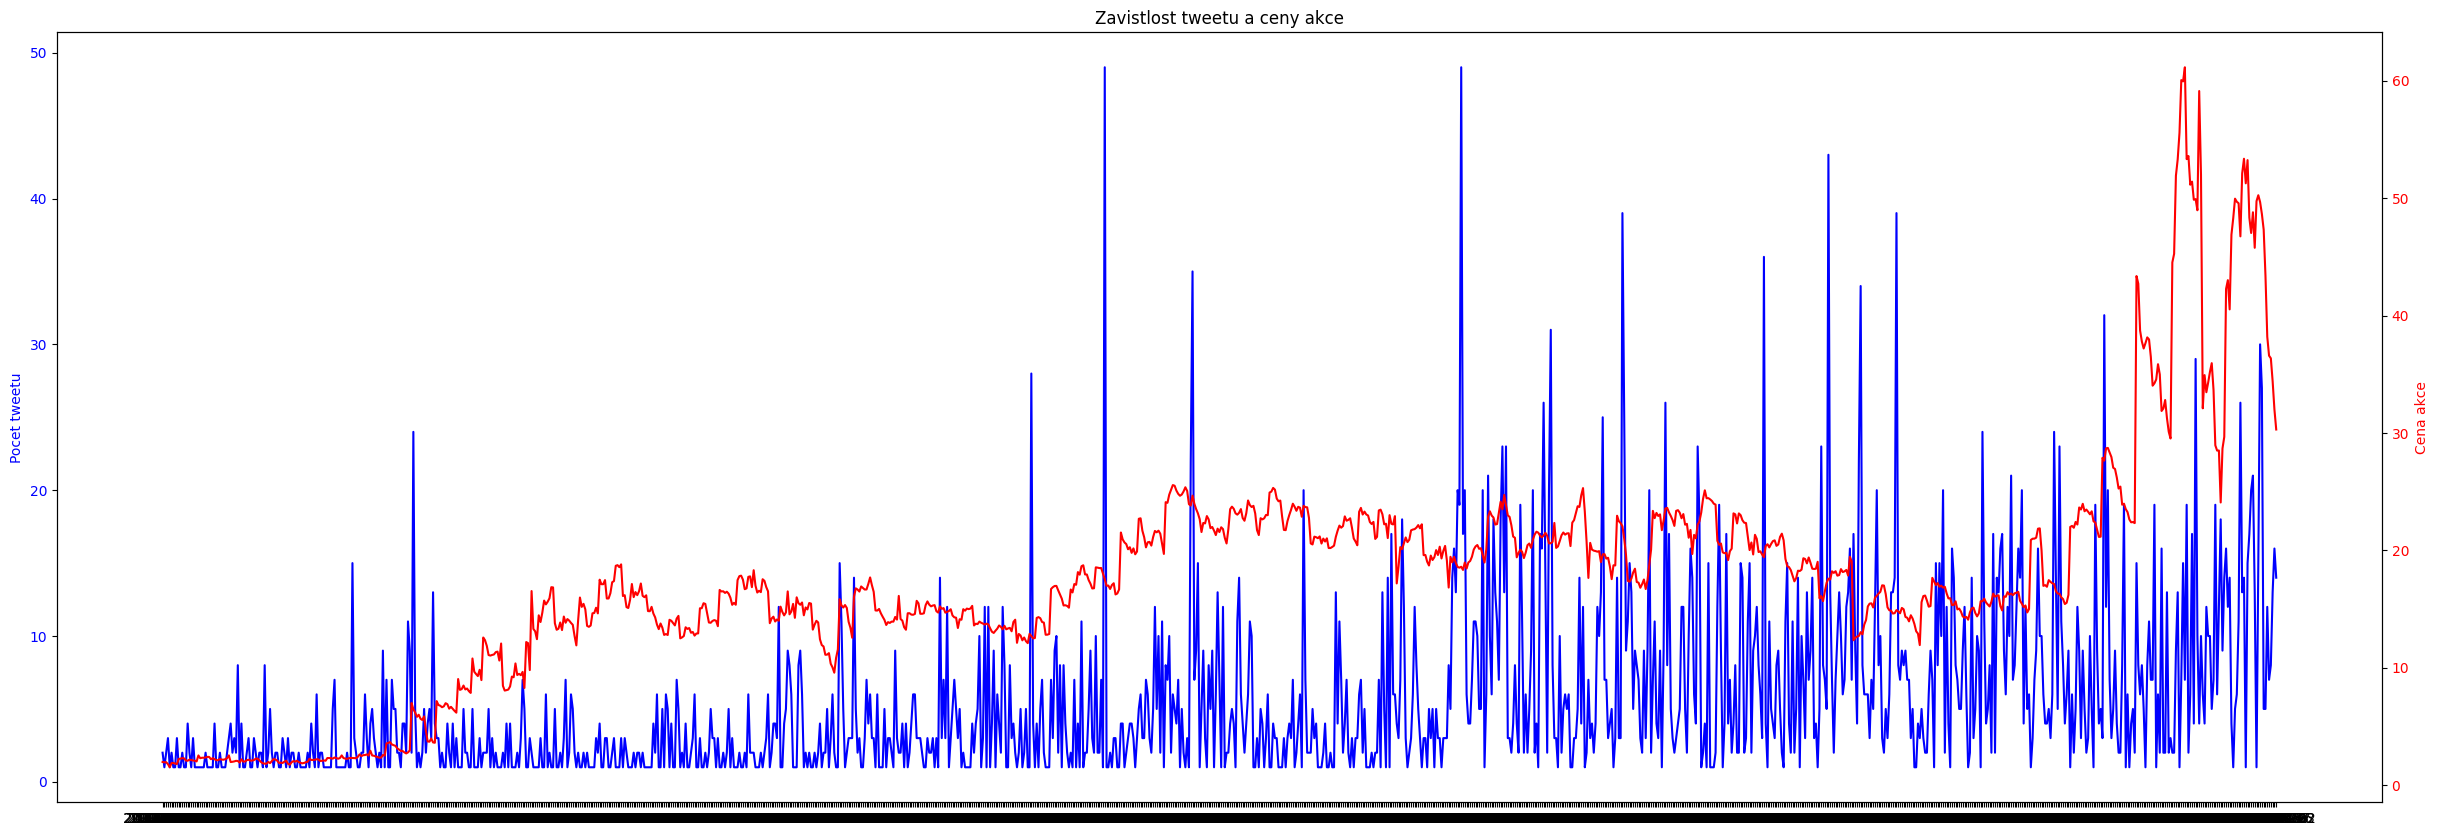

In [62]:
tweets = df['tweet_count']
stock_price = df['Close']
fig, ax1 = plt.subplots(figsize=(30, 10))
ax1.set_ylabel('Pocet tweetu', color='blue')
ax1.plot(df.index, tweets, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.set_ylabel('Cena akce', color='red')
ax2.plot(df.index, stock_price, color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.title('Zavistlost poctu tweetu a ceny akce')
plt.show()

# Zavistlost poctu retweetu a ceny akce

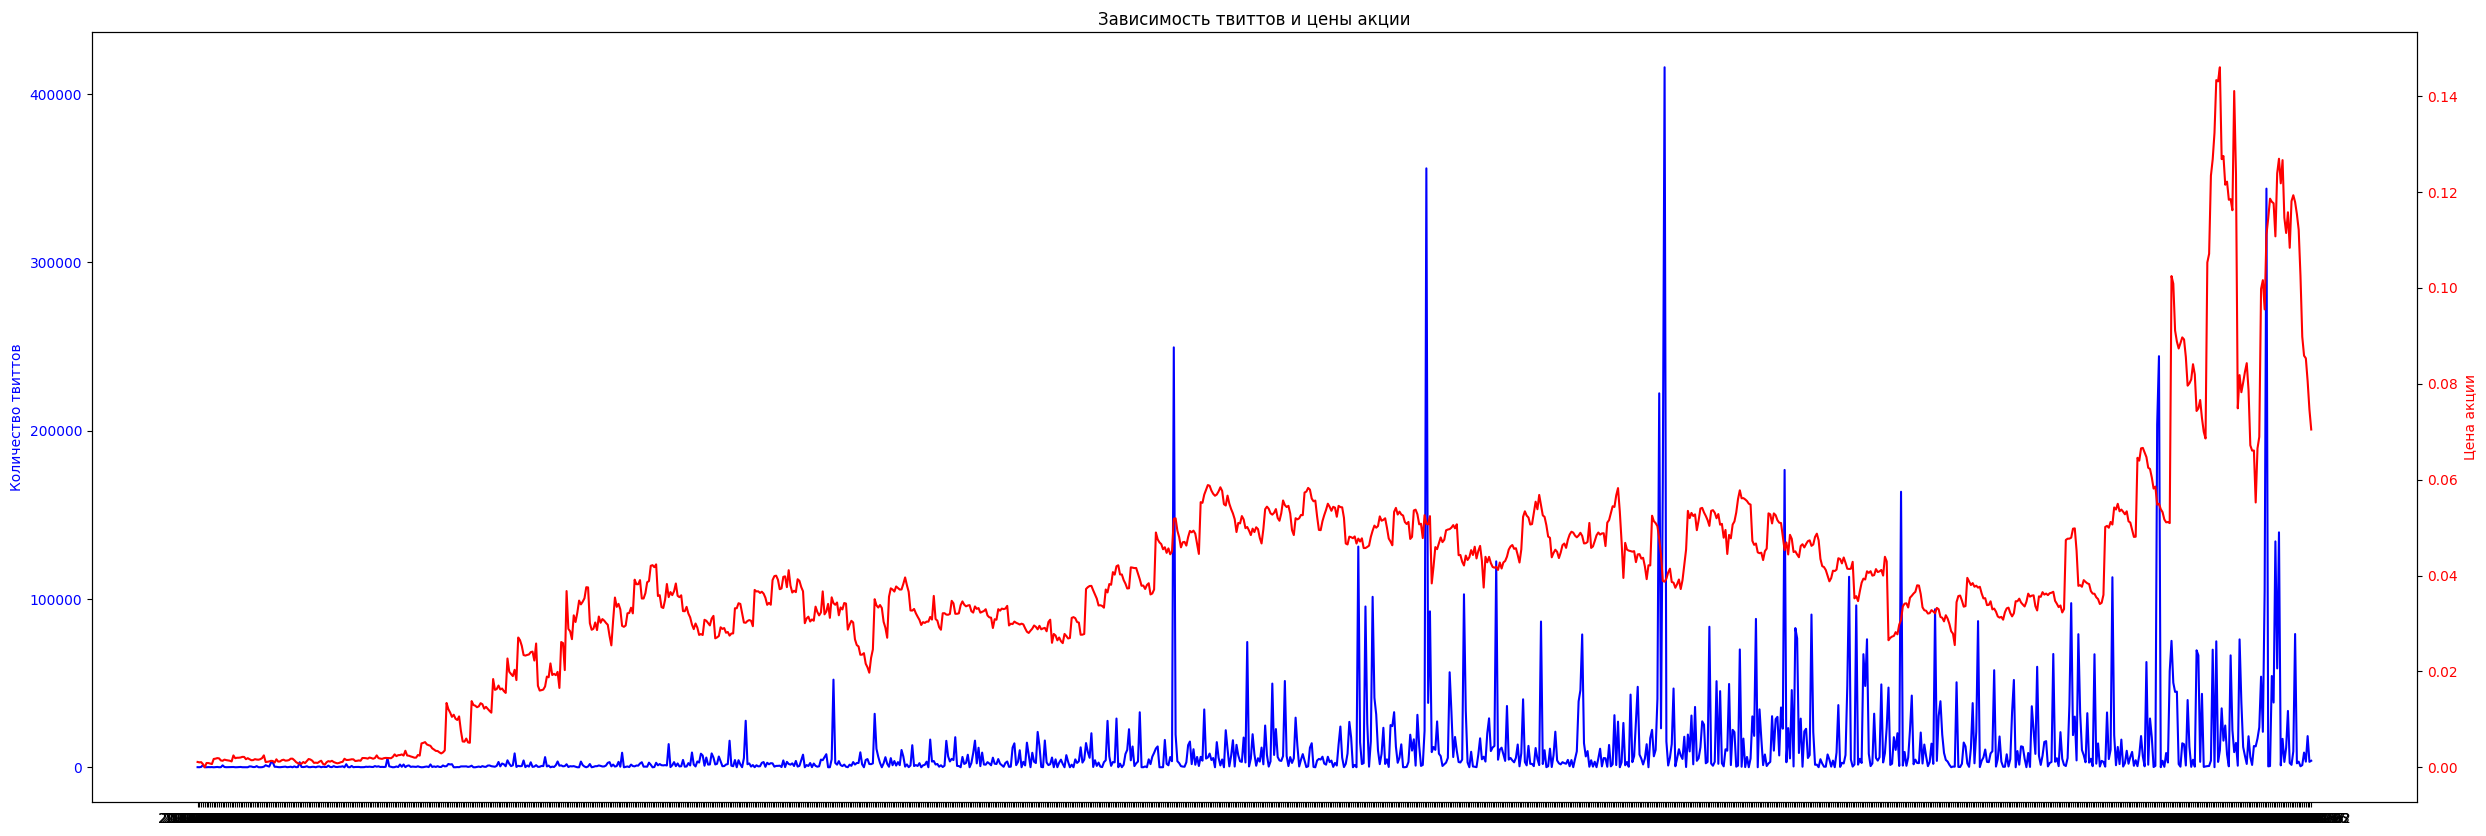

In [20]:
retweets = df['retweets']
stock_price = df['Close_n']

fig, ax1 = plt.subplots(figsize=(30, 10))

ax1.set_ylabel('Pocet retweetu', color='blue')
ax1.plot(df.index, retweets, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Cena akce', color='red')
ax2.plot(df.index, stock_price, color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Zavistlost retweetu a ceny akce')
plt.show()

# Distribuce polarity tweetu a jeho dopadu na cenu

C:\Program Files\Python311\Lib\site-packages\seaborn\axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


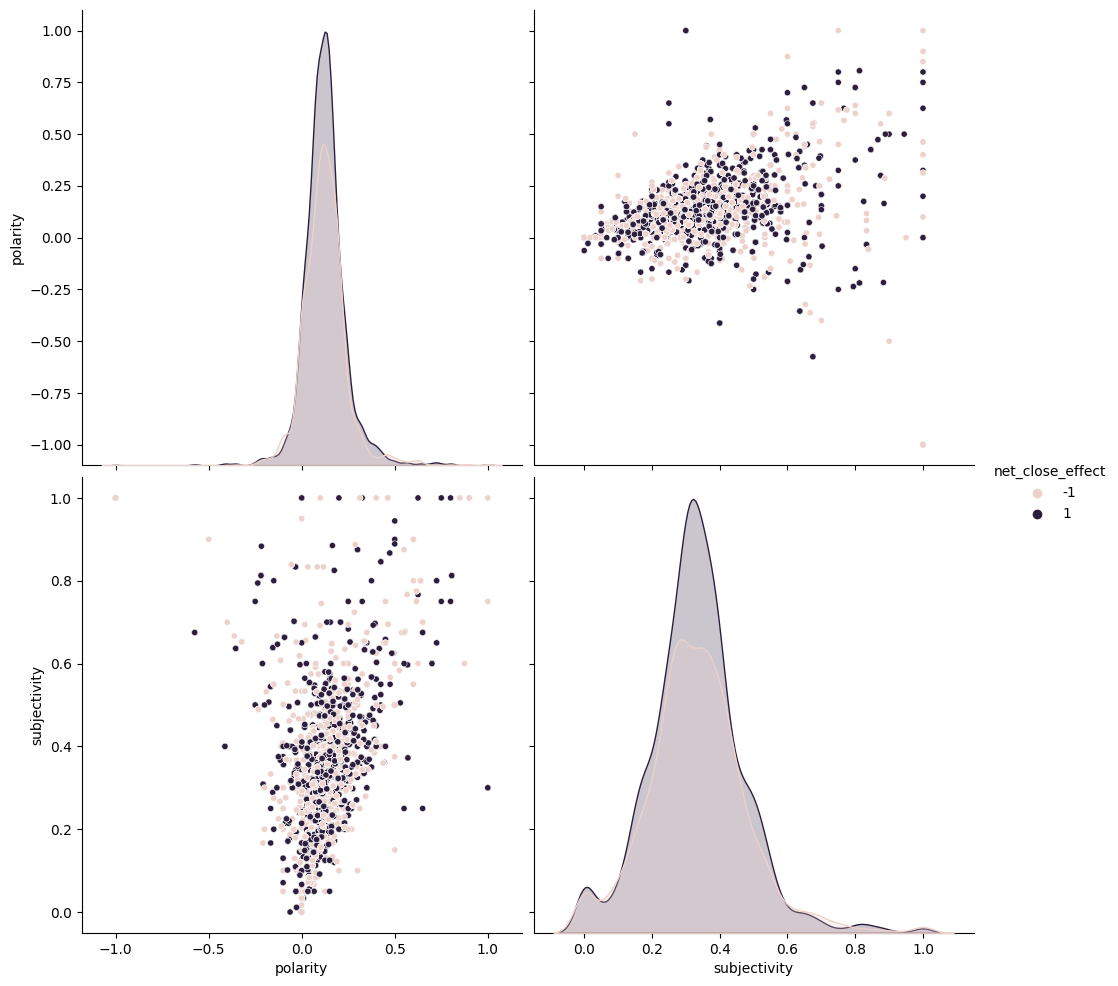

In [63]:
sns.pairplot(df[['polarity', 'subjectivity', 'net_close_effect']], hue='net_close_effect', size=5, plot_kws={"s": 20})
plt.show()

In [64]:
#Bez dneska
n_days = 1
df_mean = df.rolling(window=n_days+1).mean().shift()
df_sum = df.rolling(window=n_days+1).sum().shift()
df['neutral_n_d'] = df_sum['neutral']
df['positive_n_d'] = df_sum['positive']
df['negative_n_d'] = df_sum['negative']
df['url_news_n_d'] = df_sum['url_news']
df['closely_related_n_d'] = df_sum['closely_related']
df['other_related_n_d'] = df_sum['other_related']
df['money_related_n_d'] =  df_sum['money_related']
df['volume_n_d']= df_mean['Volume']
df['tesla_related_n_d'] = df_sum['tesla_related']
df['hashtags_c_n_d'] = df_sum['hashtags_c']
df['mentions_c_n_d'] = df_sum['mentions_c']
df['retweets_n_d'] = df_sum['retweets']
df['prev_close_n'] = df_mean['prev_close']
df['close_n_d'] = df_mean['Close']
df['tweet_count_n'] = df_sum['tweet_count']
df['polarity_n_d'] = df_mean['polarity']
df['subjectivity_n_d'] = df_mean['subjectivity']
df['to_c_n_d'] = df_sum['to_c']
df.fillna(0, inplace=True)

C:\Users\OMEN\AppData\Local\Temp\ipykernel_32304\658810413.py:3: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['category', 'text', 'to'], dtype='object')
  df_mean = df.rolling(window=n_days+1).mean().shift()
C:\Users\OMEN\AppData\Local\Temp\ipykernel_32304\658810413.py:4: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['category', 'text', 'to'], dtype='object')
  df_sum = df.rolling(window=n_days+1).sum().shift()


## Linear regression

In [65]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import chi2
# Importing libraries
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

import numpy as np

results = None

def weighted_regression(X):
    global results
    
    y = df['Close']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    X_train = sm.add_constant(X_train)  # Добавляем константный столбец для интерцепта
    X_test = sm.add_constant(X_test)


    model = sm.WLS(y_train, X_train)
 
    results = model.fit()
 
    y_pred = results.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Mean Squared Error (MSE):", mse)
    print("R-squared (R2):", r2)
    
    plt.scatter(y_test, y_pred, c='b')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Porovnani Skutecne hodnoty a Predpokladane hodnoty')
    plt.ylabel('Predpokladane hodnoty')
    plt.title('Skutecne hodnoty')
    plt.show()
    
    names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']
    residuals = y_test - y_pred
    residuals_squared = residuals**2
    test_result = sms.het_breuschpagan(results.resid, results.model.exog)
    temp = lzip(names, test_result)
 
    if(temp[1][1] < 0.01):
         print('Model is heteroscedastic; p-value = ',temp[1][1])
    else:
        print('Model is homoscedastic; p-value = ',temp[1][1])
    
    print(results.params)

    plt.scatter(y_pred, residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predpokladane hodnoty')
    plt.ylabel('Zbytky')
    plt.title('Graf zbytku')
    plt.show()
    


# Bez metrik tohoto dne

Mean Squared Error (MSE): 0.3663749058296832
R-squared (R2): 0.9963776586609653


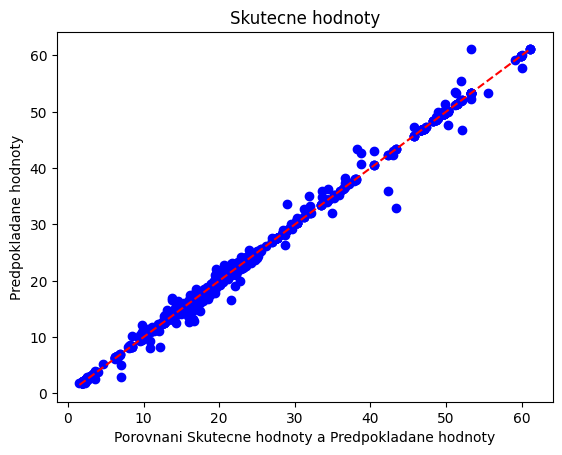

Model is heteroscedastic; p-value =  0.001797313096796319
const                  5.895536e-01
neutral_n_d           -2.523183e-01
positive_n_d          -2.559464e-01
negative_n_d          -2.642371e-01
url_news_n_d          -2.071259e-02
closely_related_n_d   -1.877962e-03
other_related_n_d      1.282466e-05
money_related_n_d      3.893947e-03
tesla_related_n_d     -5.177063e-04
hashtags_c_n_d        -1.029688e-01
mentions_c_n_d        -5.370075e-03
retweets_n_d           1.949988e-07
close_n_d              9.983148e-01
polarity_n_d           6.533295e-02
subjectivity_n_d      -4.661403e-02
to_c_n_d              -1.026807e-02
tweet_count_n         -1.386586e-03
dtype: float64


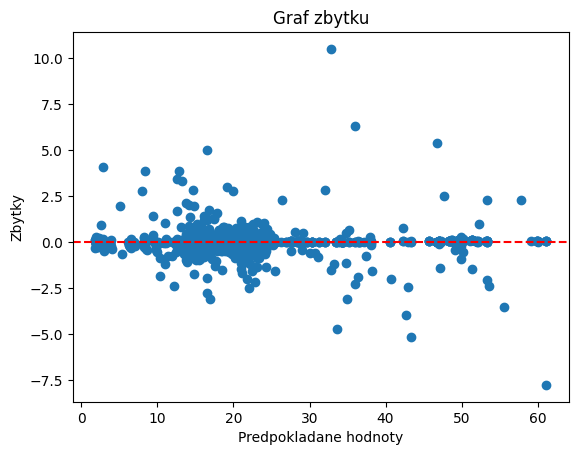

In [42]:
# bez metrik tohoto dne
weighted_regression(df[['neutral_n_d','positive_n_d','negative_n_d', 'url_news_n_d', 'closely_related_n_d', 'other_related_n_d',
            'money_related_n_d', 'tesla_related_n_d', 'hashtags_c_n_d', 'mentions_c_n_d', 'retweets_n_d', 'close_n_d',
            'polarity_n_d', 'subjectivity_n_d', 'to_c_n_d', 'tweet_count_n']])

# Jen metriky tohoto dne

Mean Squared Error (MSE): 2.8999134556015567
R-squared (R2): 0.9713286138796531


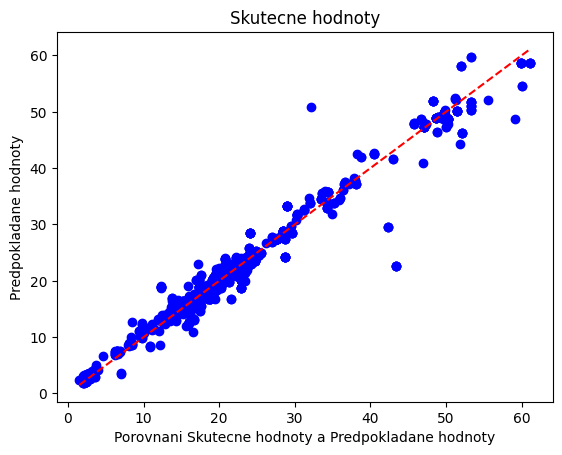

Model is heteroscedastic; p-value =  8.759882599614046e-24
const              0.812552
positive          -0.174659
negative           0.029992
neutral           -0.172172
mentions_c        -0.048913
Volume             0.510678
retweets           0.000003
other_related      0.000008
tesla_related     -0.035806
money_related     -0.341404
to_c              -0.016969
closely_related    0.013350
url_news           0.328913
url_video         -0.051710
hashtags_c        -0.729371
mentions_c        -0.048913
prev_close         0.959895
Volume             0.510678
dtype: float64


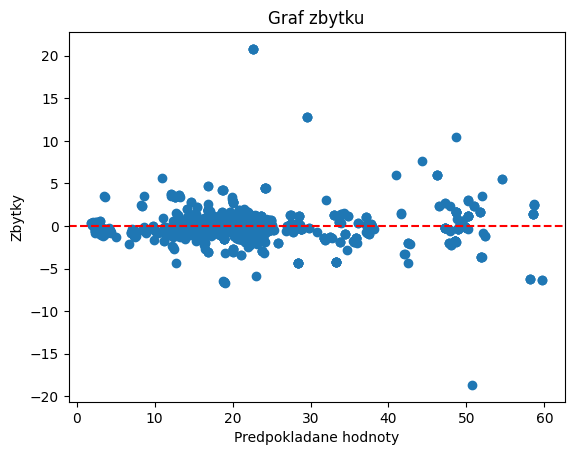

In [36]:
# jen s metriky toho dne
weighted_regression(df[['positive', 'negative', 'neutral', 'mentions_c', 'Volume', 'retweets', 'other_related', 'tesla_related',
        'money_related', 'to_c', 'closely_related', 'url_news', 'url_video', 'hashtags_c', 'mentions_c', 'prev_close', 'Volume']])

# Vsechno dohromady

Mean Squared Error (MSE): 0.3581296668059742
R-squared (R2): 0.9964591791736711


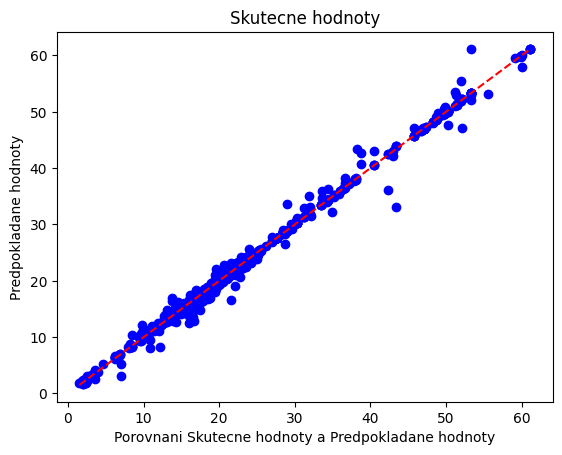

Model is homoscedastic; p-value =  0.018498164567959545
const                  5.921793e-01
positive               2.575838e-02
negative               5.930451e-02
neutral                2.354026e-02
mentions_c            -9.692236e-03
Volume                 2.567835e-01
retweets               1.721441e-06
other_related         -9.531351e-06
tesla_related         -3.286865e-02
money_related         -2.572334e-01
to_c                   4.298212e-02
closely_related        3.754766e-02
url_news               1.684212e-01
url_video             -1.175371e-02
hashtags_c            -1.446350e-01
mentions_c            -9.692236e-03
prev_close            -2.659899e-02
neutral_n_d           -2.790943e-01
positive_n_d          -2.837379e-01
negative_n_d          -2.908545e-01
url_news_n_d          -9.069350e-02
closely_related_n_d   -2.000772e-02
other_related_n_d      3.017772e-06
money_related_n_d      1.197633e-01
tesla_related_n_d      1.437365e-02
hashtags_c_n_d        -4.346726e-02
mentions

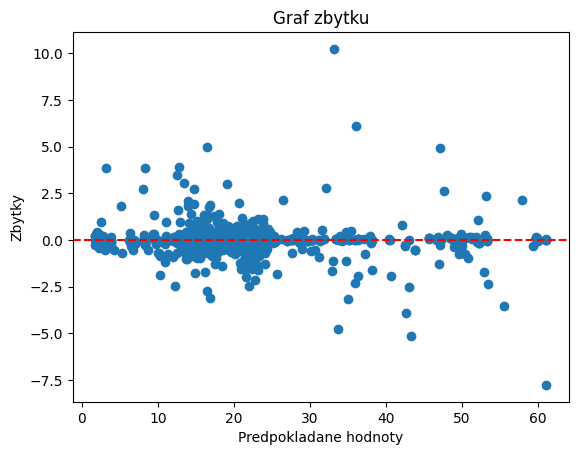

In [38]:
# s metriky tohoto dne
X = df[['positive', 'negative', 'neutral', 'mentions_c', 'Volume', 'retweets', 'other_related', 'tesla_related',
        'money_related', 'to_c', 'closely_related', 'url_news', 'url_video', 'hashtags_c', 'mentions_c','prev_close',
        'neutral_n_d', 'positive_n_d', 'negative_n_d', 'url_news_n_d', 'closely_related_n_d', 'other_related_n_d',
        'money_related_n_d', 'tesla_related_n_d', 'hashtags_c_n_d', 'mentions_c_n_d', 'retweets_n_d', 'close_n_d',
        'polarity_n_d', 'subjectivity_n_d', 'to_c_n_d']]
weighted_regression(X)

## Klasterizace (cena, polarita - v korelaci neutralni nejvic zvysuje cenu). Chceme vedet distribuci klasteru s tweety, ktere zvysily cenu.

C:\Program Files\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


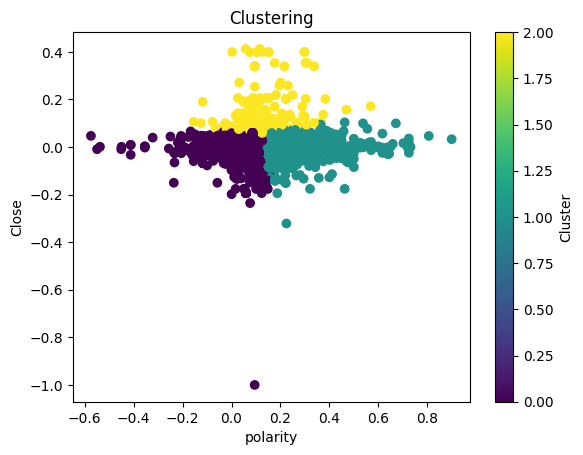

In [16]:
selected = df[['polarity_n_d', 'Close_n_diff_%']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected)
X = selected

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(scaled_features)
labels = kmeans.labels_

plt.scatter(selected['polarity_n_d'],selected['Close_n_diff_%'], c=labels, cmap='viridis')
plt.xlabel('polarity')
plt.ylabel('Close')
plt.title('Clustering')
plt.colorbar(label='Cluster')
plt.show()
